# Analyzing Chinook Music Store Data

In [6]:
import sqlite3
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

## Create Helper Functions

- **run_query()** function takes a SQL query as an argument and returns a pandas dataframe
- **run_command()** function that takes a SQL command as an argument and executes it using the sqlite module.
- **show_tables()** function that calls the run_query() function to return a list of all tables and views in the database.

In [4]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    
    query = """
    SELECT
        name,
        type
    FROM
        sqlite_master
    WHERE type IN ('table', 'view')
    """
    
    return run_query(query)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums To Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name | Genre |
|-------------|-------|
| Regal       |Hip-Hop|
| Red Tone    | Punk  |
| Meteor and the Girls| Pop |
| Slim Jim Bites | Blues |


Which albums should Chinook purchase? The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [7]:
q1 = """
    WITH usa AS 
            (
            SELECT invoice_id
            FROM invoice
            WHERE billing_country = 'USA'
            ),
    sales AS 
            (
            SELECT
                i.track_id,
                sum(i.quantity) as quantity
            FROM 
                invoice_line i
                    INNER JOIN usa
                    ON i.invoice_id = usa.invoice_id
            GROUP BY track_id
            ),
    category AS 
            (
            SELECT 
                s.track_id, 
                s.quantity, 
                g.name as genre
            FROM
                sales s
                    LEFT JOIN track t
                    ON s.track_id = t.track_id
                    LEFT JOIN genre g
                    ON g.genre_id = t.genre_id
            )
    SELECT
        genre,
        SUM(quantity) as "tracks_sold",
        ROUND((SUM(quantity) / (SELECT TOTAL(quantity) FROM category) * 100), 2) 
            AS "percentage_sold"
    FROM category 
    GROUP BY genre
    ORDER BY 2 DESC;
"""

In [8]:
genre_sales = run_query(q1)
run_query(q1)

,genre,tracks_sold,pct_tracks_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


### The following graph shows the sales for the USA and makes for easier reading than the table

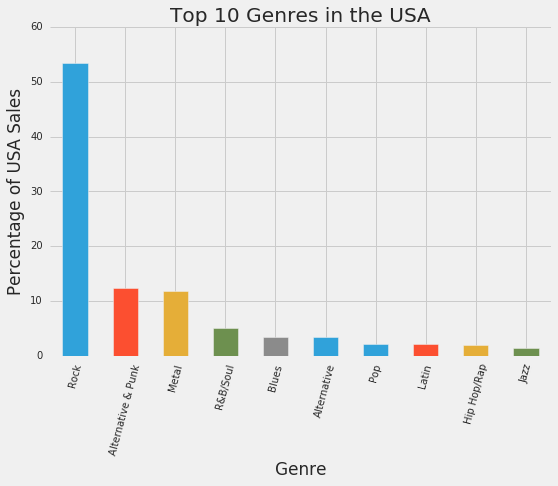

In [12]:
genre_sales.set_index("genre",drop=True,inplace=True)
ax1 = genre_sales['pct_tracks_sold'].sort_values(ascending=False).head(10).plot.bar(rot=75)
ax1.set_xlabel("Genre")
ax1.set_ylabel("Percentage of USA Sales")
ax1.set_title("Top 10 Genres in the USA")
for spine in ax1.spines:
    ax1.spines[spine].set_visible(False)
ax1.tick_params(left=False, bottom=False)

## Analyzing Employee Sales Performance

Each customer in the Chinook store gets assigned to a sales support agent. Find the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.

In [13]:
q2 = """
    WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) AS total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name AS employee,
    SUM(csrs.total) AS total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY employee;
"""

In [19]:
sales_df = run_query(q2)
sales_df.head()


,employee,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


## Analyzing Sales by Country

**You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.**

In particular, you have been directed to calculate data, for each country, on the:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value


In [23]:
q3 = """
with 
    billings AS 
            (
            SELECT  
                c.country,
                COUNT(DISTINCT c.customer_id) as num_customer,
                COUNT(DISTINCT i.invoice_id) as num_invoice,
                TOTAL(i.total) as sales
            FROM 
                customer c
                    LEFT JOIN invoice i
                    ON c.customer_id = i.customer_id
            GROUP BY c.country
            ),
    world AS
            (
            SELECT
                CASE 
                    WHEN num_customer > 1 THEN country
                    ELSE "Rest Of World"
                END AS country_alias,
                n_customer,
                n_invoice,
                sales,
                CASE
                    WHEN n_customer > 1 THEN 0
                    ELSE 1
                END AS sort_col
            FROM
                billings
            )
            SELECT 
                country_alias AS country,
                SUM(n_customer) AS n_customers,
                SUM(n_invoice) AS n_invoices,
                TOTAL(sales) AS ttl_sales,
                ROUND(CAST(TOTAL(sales) AS float) / CAST(sum(n_invoice) AS float),2) AS avg_invoice_ttl,
                ROUND(CAST(total(sales) AS float) / CAST(sum(n_customer) AS float),2) AS avg_cust_spend,
                ROUND(CAST(SUM(n_invoice) AS float) / CAST(SUM(n_customer) AS float), 2) AS invoices_per_cust
            FROM world
            GROUP BY country
            ORDER BY 
                sort_col, 
                ttl_sales desc;

            """

In [24]:
world = run_query(q3)
world = world.set_index('country')
run_query(q3)

,country,n_customers,n_invoices,ttl_sales,avg_invoice_ttl,avg_cust_spend,invoices_per_cust
0,USA,13,131,1040.49,7.94,80.04,10.08
1,Canada,8,76,535.59,7.05,66.95,9.50
2,Brazil,5,61,427.68,7.01,85.54,12.20
3,France,5,50,389.07,7.78,77.81,10.00
4,Germany,4,41,334.62,8.16,83.65,10.25
5,Czech Republic,2,30,273.24,9.11,136.62,15.00
6,United Kingdom,3,28,245.52,8.77,81.84,9.33
7,Portugal,2,29,185.13,6.38,92.56,14.50
8,India,2,21,183.15,8.72,91.57,10.50
9,All Other Countries,15,147,1094.94,7.45,73.00,9.80


#### Interpretation
The USA has the most customers. Further growth can be seen in the USA by increasing the average spent per customer. Canada and customers from the "Rest of World" can also be specifically targeted to increase the average spent per cutomer in those markets.

## Albums vs Individual Tracks

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

Calculate the following summary statistics:
- Number of invoices
- Percentage of invoices that are album purchases

In [25]:
q4 = """
/* Step 1 */
WITH
    invoice_first_track AS 
        (
        SELECT
            i.invoice_id,
            MIN(i.track_id) as first_track_id,
            t.album_id
        FROM
            invoice_line i
                LEFT JOIN track t
                ON i.track_id = t.track_id
        GROUP BY 1
        ),
    
    /* Step 2 */
    full_album_calc AS
        (
        SELECT ift.*,
            CASE
                WHEN
                    (
                        (
                            /* Tracks on Invoice */
                            SELECT track_id             
                            FROM invoice_line il
                            WHERE il.invoice_id = ift.invoice_id

                            EXCEPT

                            /* Tracks on Album */
                            SELECT track_id
                            FROM track t
                            WHERE ift.album_id = t.album_id

                        ) IS NULL
                    AND
                        (
                            /* Tracks on Album */
                            SELECT track_id
                            FROM track t
                            WHERE ift.album_id = t.album_id

                            EXCEPT 

                            /* Tracks on Invoice */
                            SELECT track_id             
                            FROM invoice_line il
                            WHERE il.invoice_id = ift.invoice_id

                        ) IS NULL
                    )
                THEN 1
                ELSE 0
            END as full_album
        FROM invoice_first_track ift
        )
        
/* Step 3 */
SELECT 
    ROUND(CAST(SUM(f.full_album) AS float) / CAST(COUNT(f.full_album) AS float) * 100,2) as "pct_full_album"
FROM full_album_calc f


"""

run_query(q4)

,pct_full_album
0,18.57


#### More questions can be asked like:
- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?